In [1]:
!pip install pytorch-lightning
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 6.1 MB/s 
     |████████████████████████████████| 512 kB 69.6 MB/s 
     |████████████████████████████████| 125 kB 50.8 MB/s 
--2022-12-14 20:45:19--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  3.04MB/s    in 12s     

2022-12-14 20:45:31 (2.50 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [3]:
!gzip -d facades.tar.gz
!tar -xf facades.tar

In [6]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
import pytorch_lightning as pl
from tqdm.auto import tqdm

In [7]:
TRAIN_DATA = "/content/facades/train/"
VAL_DATA = "/content/facades/val/"
TEST_DATA = "/content/facades/test/"

In [8]:
class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.filenames = glob(str(Path(path) / "*"))
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        real = image[:, :, : image_width // 2]
        condition = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)

        return real, condition

In [9]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [10]:
class UpSampleConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [11]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(in_channels, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [12]:
class PatchGAN(nn.Module):

    def __init__(self, input_channels):
        super().__init__()
        self.d1 = DownSampleConv(input_channels, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        return xn

In [13]:
adversarial_loss = nn.BCEWithLogitsLoss()
reconstruction_loss = nn.L1Loss()

In [14]:
class Pix2Pix(pl.LightningModule):

    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200, display_step=25):

        super().__init__()
        self.save_hyperparameters()
        
        self.display_step = display_step
        self.gen = Generator(in_channels, out_channels)
        self.patch_gan = PatchGAN(in_channels + out_channels)

        # intializing weights
        self.gen = self.gen.apply(_weights_init)
        self.patch_gan = self.patch_gan.apply(_weights_init)

        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()

    def _gen_step(self, real_images, conditioned_images):
        # Pix2Pix has adversarial and a reconstruction loss
        # First calculate the adversarial loss
        fake_images = self.gen(conditioned_images)
        disc_logits = self.patch_gan(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        # calculate reconstruction loss
        recon_loss = self.recon_criterion(fake_images, real_images)
        lambda_recon = self.hparams.lambda_recon

        return adversarial_loss + lambda_recon * recon_loss

    def _disc_step(self, real_images, conditioned_images):
        fake_images = self.gen(conditioned_images).detach()
        fake_logits = self.patch_gan(fake_images, conditioned_images)

        real_logits = self.patch_gan(real_images, conditioned_images)

        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        return (real_loss + fake_loss) / 2

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=lr)
        disc_opt = torch.optim.Adam(self.patch_gan.parameters(), lr=lr)
        return disc_opt, gen_opt

    def training_step(self, batch, batch_idx, optimizer_idx):
        real, condition = batch

        loss = None
        if optimizer_idx == 0:
            loss = self._disc_step(real, condition)
            self.log('PatchGAN Loss', loss)
        elif optimizer_idx == 1:
            loss = self._gen_step(real, condition)
            self.log('Generator Loss', loss)
        
        if self.current_epoch%self.display_step==0 and batch_idx==0 and optimizer_idx==1:
            fake = self.gen(condition).detach()
            display_progress(condition[0], fake[0], real[0])
        return loss

In [15]:
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
def display_progress(cond, fake, real, figsize=(10,5)):
    cond = cond.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[2].imshow(fake)
    ax[1].imshow(real)
    plt.show()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type              | Params
------------------------------------------------------------
0 | gen                   | Generator         | 54.4 M
1 | patch_gan             | PatchGAN          | 2.8 M 
2 | adversarial_criter

Training: 0it [00:00, ?it/s]

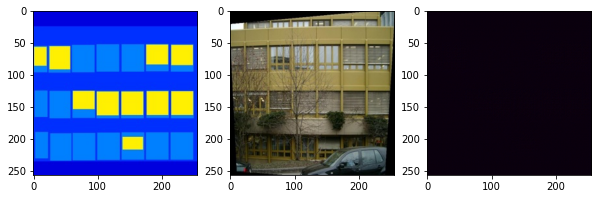

In [ ]:
dataset = FacadesDataset(TRAIN_DATA)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

pix2pix = Pix2Pix(3, 3)
trainer = pl.Trainer(max_epochs=1000, gpus=1)
trainer.fit(pix2pix, dataloader)